In [1]:
import anndata
import scanpy as sc
import pandas as pd

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80,frameon=False, figsize=(3,3),facecolor='white')

### PBMCs

In [4]:
adata_ref = sc.datasets.pbmc3k_processed()
adata = sc.datasets.pbmc68k_reduced()

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 23.5M/23.5M [00:03<00:00, 6.18MB/s]


In [9]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names].copy()
adata = adata[:, var_names].copy()

In [10]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

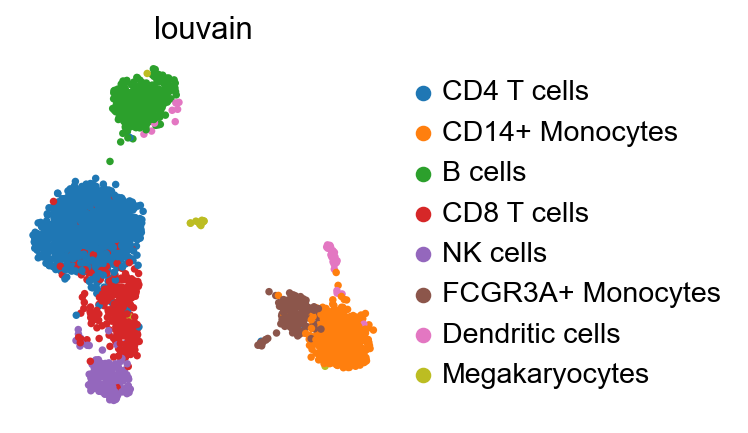

In [12]:
sc.pl.umap(adata_ref, color="louvain")

### Mapping PBMCs using ingest

In [13]:
sc.tl.ingest(adata, adata_ref, obs="louvain")

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
adata.uns["louvain_colors"] = adata_ref.uns["louvain_colors"] # fix colors

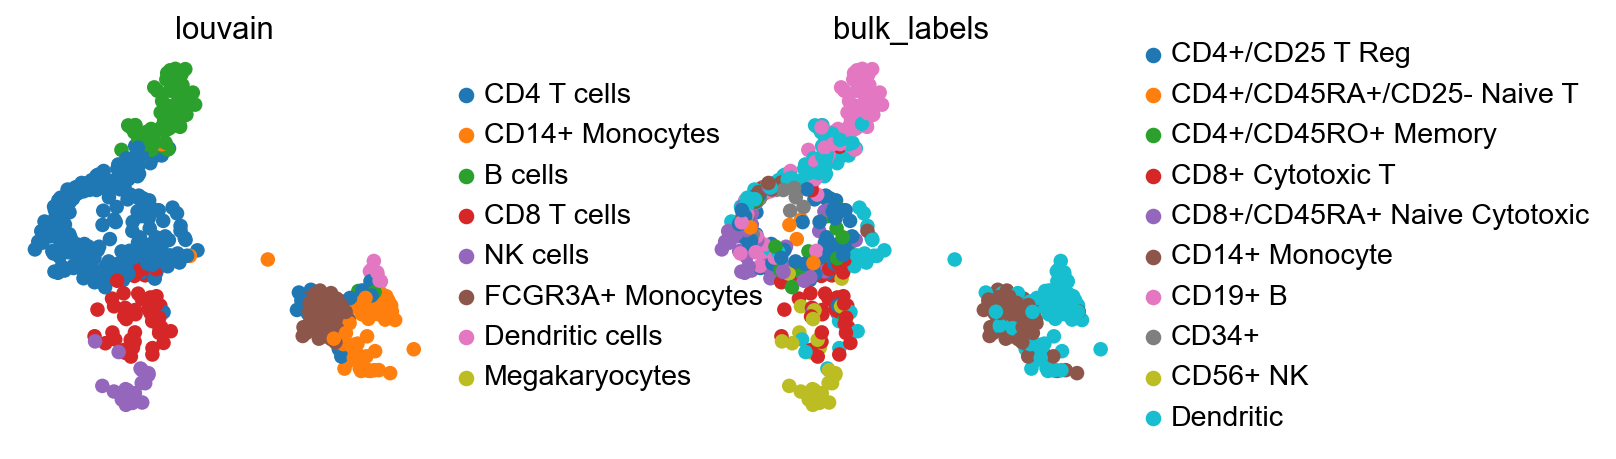

In [16]:
sc.pl.umap(adata, color=["louvain", "bulk_labels"], wspace=0.5)

In [17]:
adata_concat = anndata.concat([adata_ref, adata], label="batch", keys=["ref","new"])

In [18]:
adata_concat.obs["louvain"] = (
    adata_concat.obs["louvain"]
    .astype("category")
    .cat.reorder_categories(adata_ref.obs["louvain"].cat.categories)
)

# fix category colors
adata_concat.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]

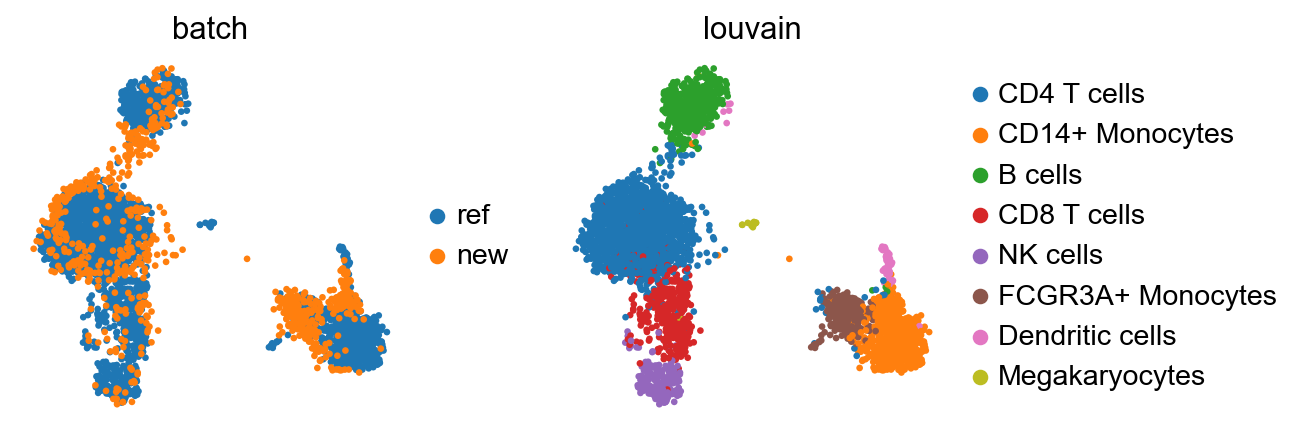

In [19]:
sc.pl.umap(adata_concat, color=["batch","louvain"])

### Using BBKNN

In [20]:
sc.tl.pca(adata_concat)

In [25]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key="batch")  # running bbknn 1.3.6

CPU times: user 739 ms, sys: 66.3 ms, total: 805 ms
Wall time: 835 ms


In [26]:
sc.tl.umap(adata_concat)

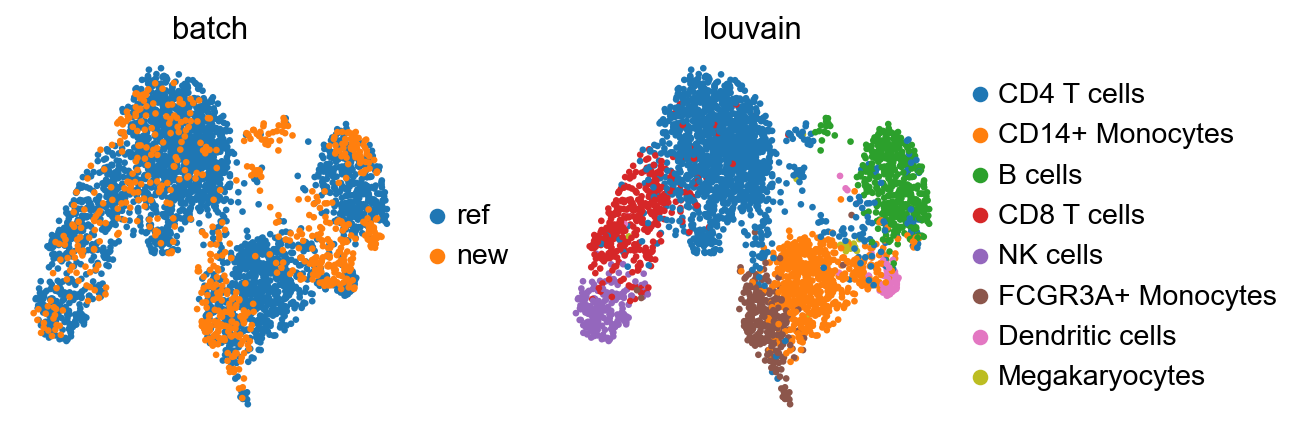

In [28]:
sc.pl.umap(adata_concat, color=["batch", "louvain"])

### Pancreas

In [29]:
adata_all = sc.read(
    "data/pancreas.h5ad",
    backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1",
)

100%|██████████| 176M/176M [00:38<00:00, 4.76MB/s] 
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_io/h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_io/h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


In [31]:
adata_all.shape

(14693, 2448)

In [33]:
counts = adata_all.obs["celltype"].value_counts()

counts.to_frame()

,count
celltype,
alpha,4214
beta,3354
ductal,1804
acinar,1368
not applicable,1154
delta,917
gamma,571
endothelial,289
activated_stellate,284


In [34]:
minority_classes = counts.index[-5:].tolist()

# actually subset
adata_all = adata_all[~adata_all.obs["celltype"].isin(minority_classes)].copy()

# reorder according to abundance
adata_all.obs["celltype"] = adata_all.obs["celltype"].cat.reorder_categories(
    counts.index[:-5].tolist()
)

### Seeing the batch effect

In [35]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

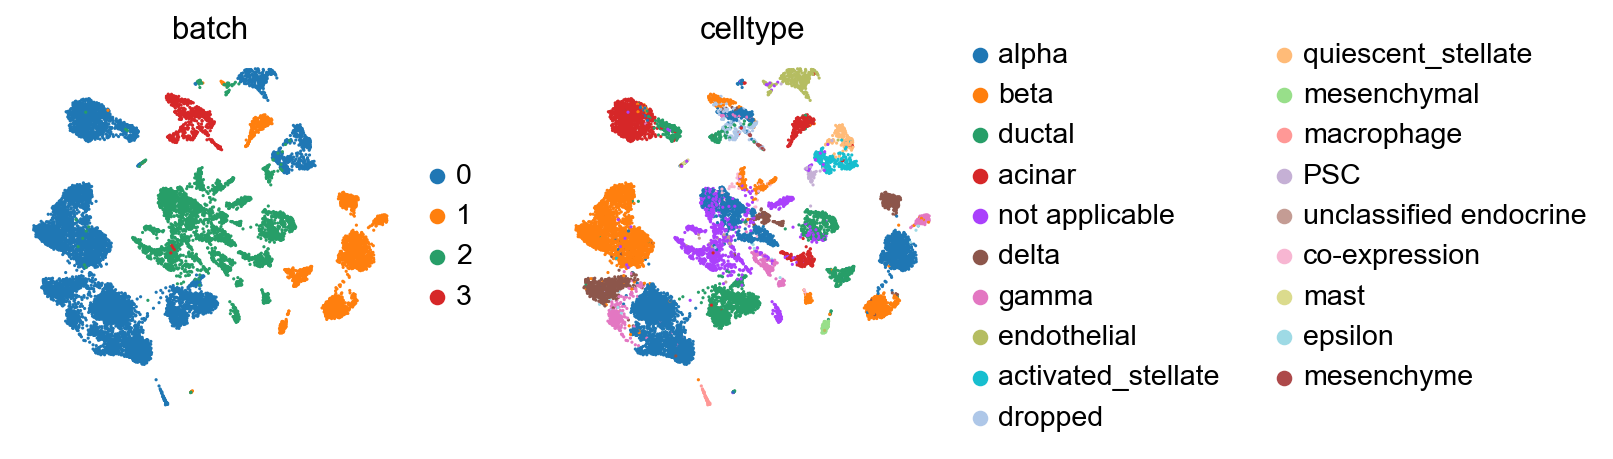

In [36]:
sc.pl.umap(
    adata_all,
    color=["batch", "celltype"],
    palette=sc.pl.palettes.vega_20_scanpy
)

### BBKNN

In [63]:
%%time
sc.external.pp.bbknn(adata_all, batch_key="batch")

CPU times: user 1.64 s, sys: 34.2 ms, total: 1.68 s
Wall time: 1.74 s


In [64]:
sc.tl.umap(adata_all)

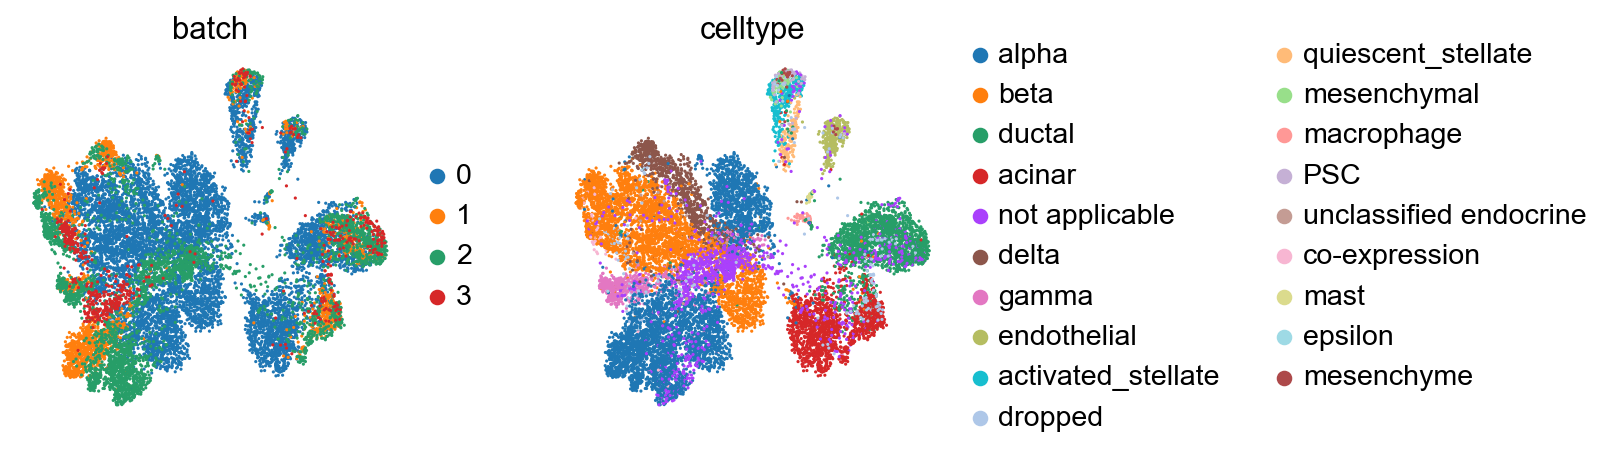

In [65]:
sc.pl.umap(adata_all, color=["batch", "celltype"])

### Mapping onto a refernece batch using ingest

In [66]:
adata_ref = adata_all[adata_all.obs["batch"] == "0"].copy()

In [67]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

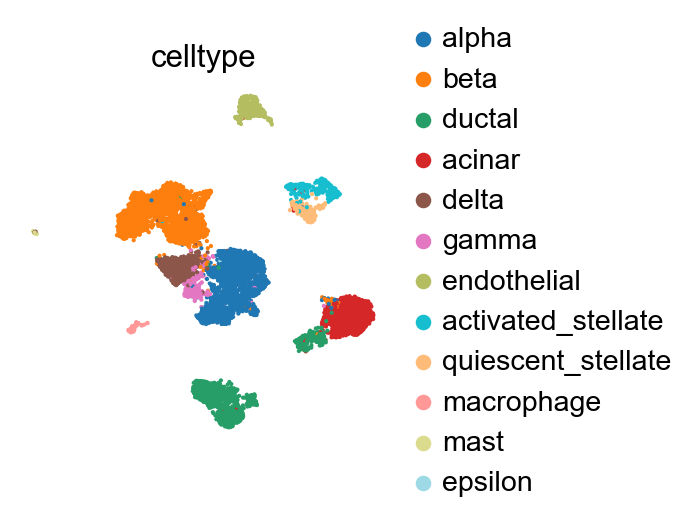

In [68]:
sc.pl.umap(adata_ref, color="celltype")

In [69]:
adatas = [adata_all[adata_all.obs["batch"] == i].copy() for i in ["1", "2", "3"]]

In [71]:
sc.settings.verbosity = 2 # a bit more logging
for iadata, adata in enumerate(adatas, 1):
    print(f"....integrating batch{iadata}")
    adata.obs["celltype_orig"] = adata.obs["celltype"]
    sc.tl.ingest(adata, adata_ref, obs="celltype")

....integrating batch1
running ingest


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:02)
....integrating batch2
running ingest


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:03)
....integrating batch3
running ingest


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:01)


In [72]:
adata_concat = anndata.concat([adata_ref, *adatas], label="batch", join="outer")

In [75]:
adata_concat.obs["celltype"] = (
    adata_concat.obs["celltype"]
    .astype("category")
    .cat.reorder_categories(adata_ref.obs["celltype"].cat.categories)
)
# fix category coloring
adata_concat.uns["celltype_colors"] = adata_ref.uns["celltype_colors"]

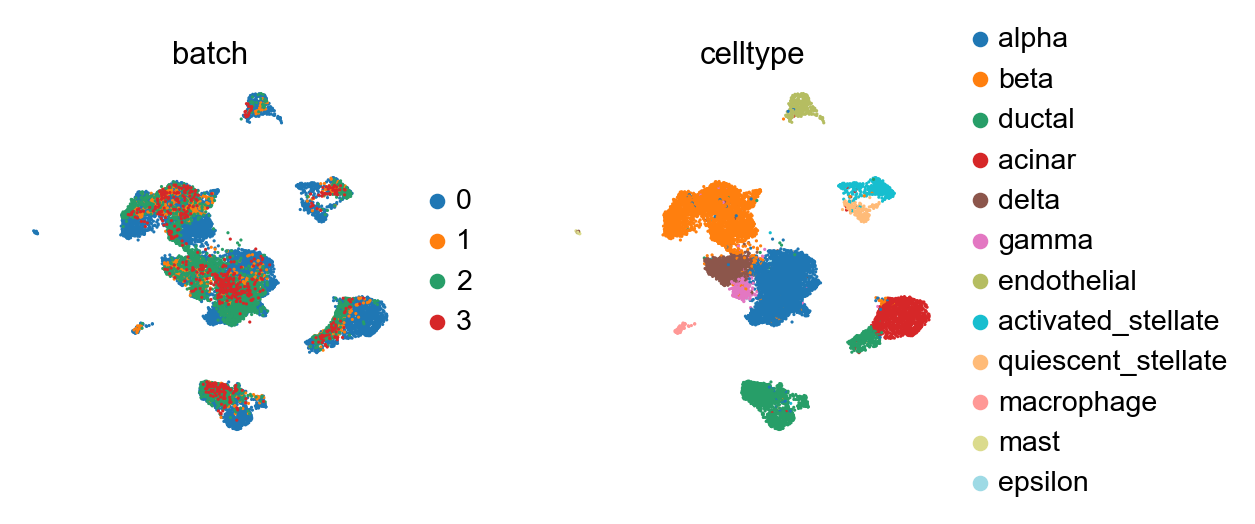

In [76]:
sc.pl.umap(adata_concat, color=["batch", "celltype"])

### Evaluating consistency

In [77]:
adata_query = adata_concat[adata_concat.obs["batch"].isin(["1", "2", "3"])].copy()

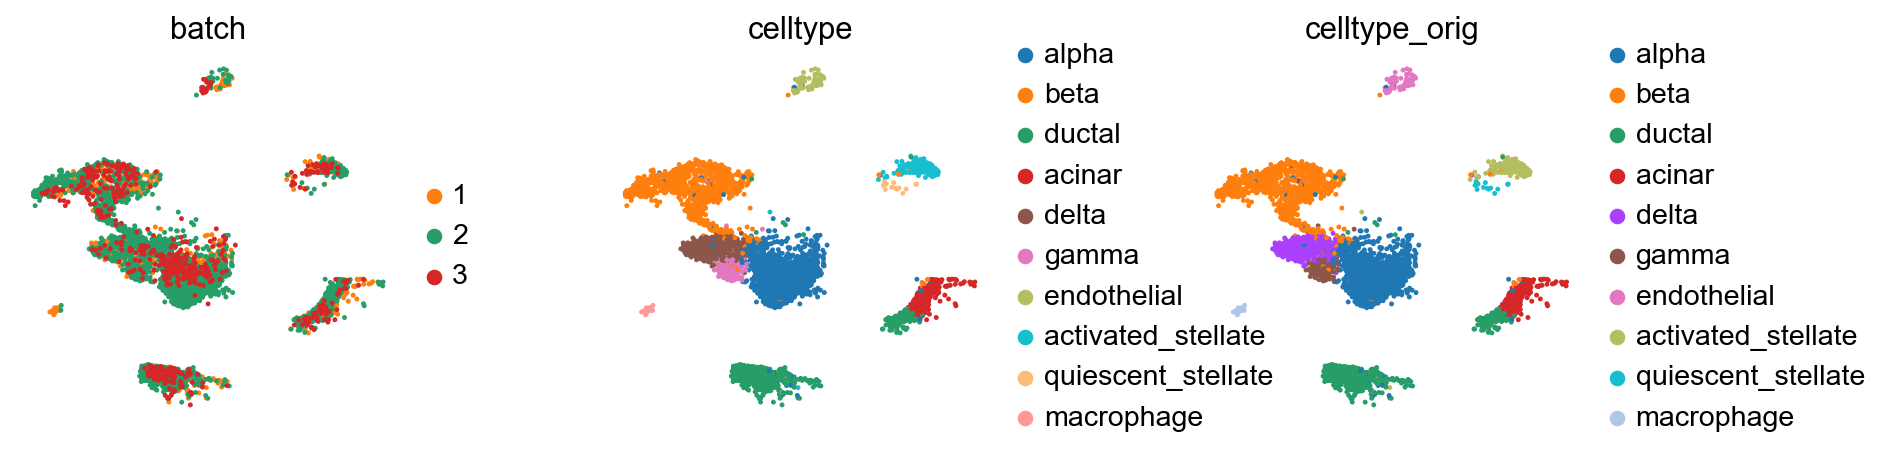

In [78]:
sc.pl.umap(adata_query, color=["batch", "celltype", "celltype_orig"], wspace=0.4)

In [79]:
# intersected categories
conserved_categories = adata_query.obs["celltype"].cat.categories.intersection(
    adata_query.obs["celltype_orig"].cat.categories
)
# intersect categories
obs_query_conserved = adata_query.obs.loc[
    adata_query.obs["celltype"].isin(conserved_categories)
    & adata_query.obs["celltype_orig"].isin(conserved_categories)
].copy()
# remove unused categories
obs_query_conserved["celltype"] = obs_query_conserved[
    "celltype"
].cat.remove_unused_categories()
# remove unused categories and fix category ordering
obs_query_conserved["celltype_orig"] = (
    obs_query_conserved["celltype_orig"]
    .cat.remove_unused_categories()
    .cat.reorder_categories(obs_query_conserved["celltype"].cat.categories)
)

In [80]:
pd.crosstab(obs_query_conserved["celltype"], obs_query_conserved["celltype_orig"])

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial,activated_stellate,quiescent_stellate,macrophage
celltype,,,,,,,,,,
alpha,2219,0,0,0,0,0,0,0,0,0
beta,0,1542,0,0,0,0,0,0,0,0
ductal,0,0,1074,0,0,0,0,0,0,0
acinar,0,0,0,289,0,0,0,0,0,0
delta,0,0,0,0,509,0,0,0,0,0
gamma,0,0,0,0,0,209,0,0,0,0
endothelial,0,0,0,0,0,0,58,0,0,0
activated_stellate,0,0,0,0,0,0,0,184,0,0
quiescent_stellate,0,0,0,0,0,0,0,0,14,0


### All cell types

In [81]:
pd.crosstab(adata_query.obs["celltype"], adata_query.obs["celltype_orig"])

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial,activated_stellate,quiescent_stellate,macrophage
celltype,,,,,,,,,,
alpha,2219,0,0,0,0,0,0,0,0,0
beta,0,1542,0,0,0,0,0,0,0,0
ductal,0,0,1074,0,0,0,0,0,0,0
acinar,0,0,0,289,0,0,0,0,0,0
delta,0,0,0,0,509,0,0,0,0,0
gamma,0,0,0,0,0,209,0,0,0,0
endothelial,0,0,0,0,0,0,58,0,0,0
activated_stellate,0,0,0,0,0,0,0,184,0,0
quiescent_stellate,0,0,0,0,0,0,0,0,14,0


### Density plot

In [82]:
sc.tl.embedding_density(adata_concat, groupby="batch")

computing density on 'umap'


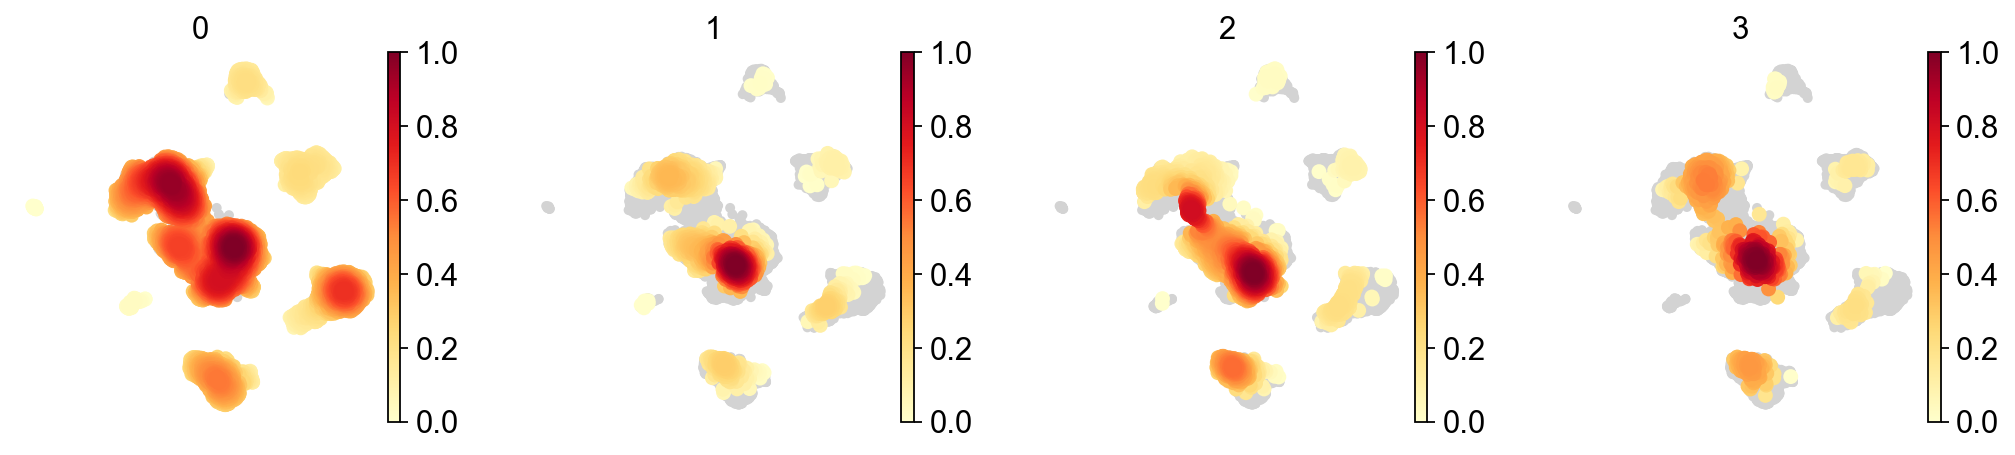

In [83]:
sc.pl.embedding_density(adata_concat, groupby="batch")

### Partial visualizaton of a subset of groups in embedding

In [84]:
import matplotlib.pyplot as plt

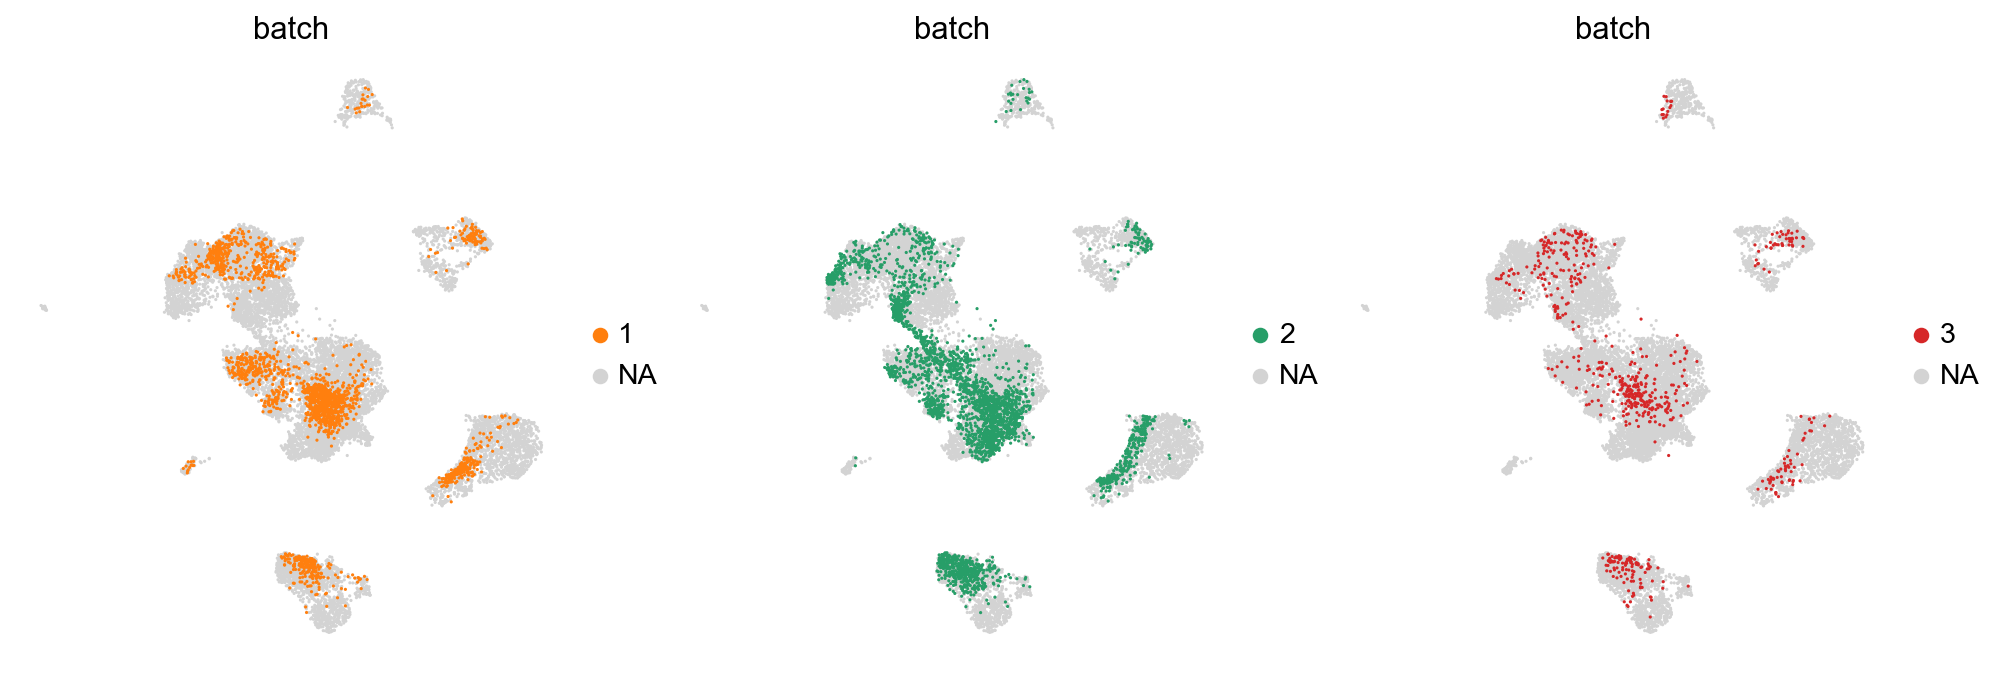

In [85]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

for batch, ax in zip (["1","2","3"], axes):
    sc.pl.umap(adata_concat, color="batch", groups=[batch], ax=ax, show=False)